# Libraries

In [9]:
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import random
import pandas as pd
import torch
import numpy as np

# Prepare Data

In [10]:
train_set = pd.read_csv("train.csv")
test_set = pd.read_csv("test.csv")
train_set

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [11]:
x_train = train_set.drop("SalePrice", axis=1).drop("Id", axis=1)
x_train_tensor = torch.from_numpy(x_train.apply(LabelEncoder().fit_transform).values).to(torch.float32)/1000
y_train = train_set.loc[:, "SalePrice"].values
y_train_tensor = torch.from_numpy(y_train).to(torch.long)
train_tensor_dataset = TensorDataset(x_train_tensor, y_train_tensor)

BATCH = 64
train_loader = DataLoader(train_tensor_dataset, BATCH, shuffle=True)

# Model

In [12]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(79, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 512)
        self.fc4 = nn.Linear(512,256)
        self.fc5 = nn.Linear(256, 1)
    
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = F.tanh(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

# Train Function

In [13]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = torch.sqrt(criterion(outputs.squeeze(), labels.float()))
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    average_loss = running_loss / len(train_loader)
    return average_loss

# Plot Loss

In [14]:
model = MLP()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

NUM_EPOCHS = 5000
losses = []
for epoch in range(NUM_EPOCHS):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    losses.append(train_loss)

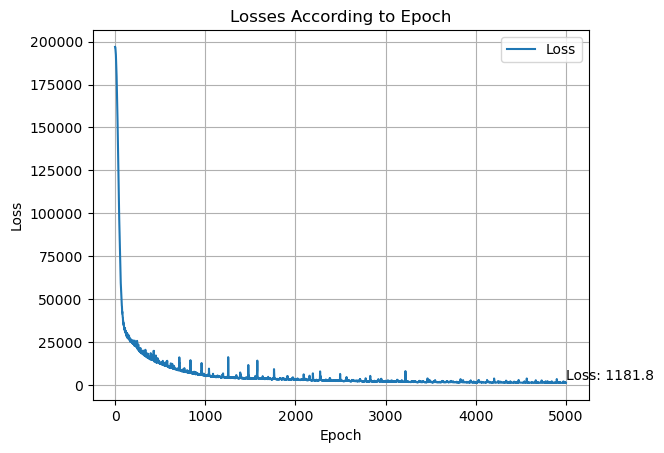

In [15]:
plt.plot(range(NUM_EPOCHS), losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Losses According to Epoch')
plt.legend()
plt.grid()
plt.text(NUM_EPOCHS, losses[-1], f'Loss: {losses[-1]:.1f}', ha='left', va='bottom')
plt.show()

In [16]:
id = random.randint(0, len(train_set))
predict = model(x_train_tensor[id])
print(f'Home ID: {id}\nActual Price: {float(y_train_tensor[id]):.4f}\nPredicted Price: {float(predict):.4f}\nDifferences Between: {float(abs(predict - y_train_tensor[id])):.4f}')

Home ID: 1430
Actual Price: 192140.0000
Predicted Price: 192582.6875
Differences Between: 442.6875
